# Setup

In [ ]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
from config import *
from path import get_eval_prs_root_path, GTS_PATH
from data import describe_da, get_significant_classes, image_UIDs, compute_results_da_class_splitted, CLASS_MAP, CLASSES

import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob
import xarray as xr

# Assessment

In [49]:
exp_name = "after_fast_prompter"

In [50]:
exp_path = get_eval_prs_root_path("LRASPP_MobileNet_V3", "class-splitted") / "gemma3:12b-it-qat" / exp_name
exp_path

PosixPath('/home/olivieri/exp/my_data/by_model/LRASPP_MobileNet_V3/class-splitted/eval_prs/gemma3:12b-it-qat/after_fast_prompter')

In [51]:
var_names = [os.path.splitext(os.path.basename(path))[0] for path in glob(f"{exp_path}/*.jsonl")]
var_names

['SepMasks_Ovr_1fs', 'SepMasks_Ovr_1fs_2']

In [52]:
data_da = compute_results_da_class_splitted(exp_path)

## Pred

In [53]:
display(describe_da(data_da.sel(metric="pred").mean("pos_class"), dims_to_agg=["img_idx"]))
display(describe_da(data_da.sel(metric="pred").mean("pos_class").mean("img_idx"), dims_to_agg=["var"]))

stat,mean,std,min,max
var,,,,
SepMasks_Ovr_1fs,0.647890,0.39513,0.0,1.0
SepMasks_Ovr_1fs_2,0.738186,0.38247,0.0,1.0


stat
mean    0.693038
std     0.063848
min     0.647890
max     0.738186
dtype: float64

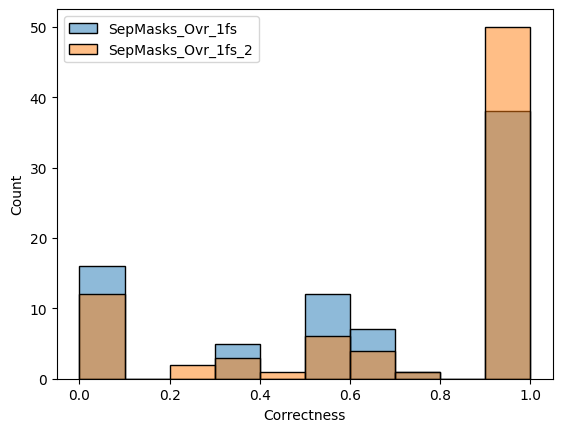

In [54]:
[sns.histplot(data_da.sel(metric="pred").mean("pos_class").loc[var_n], bins=10, alpha=0.5, label=var_n)
 for var_n in var_names]
plt.xlabel('Correctness')
plt.ylabel('Count')
plt.legend()

## Score

In [55]:
display(describe_da(data_da.sel(metric="score").mean("pos_class"), dims_to_agg=["img_idx"]))
display(describe_da(data_da.sel(metric="score").mean("pos_class").mean("img_idx"), dims_to_agg=["var"]))

stat,mean,std,min,max
var,,,,
SepMasks_Ovr_1fs,3.258861,1.225924,1.000000,5.0
SepMasks_Ovr_1fs_2,3.485443,1.208029,0.666667,5.0


stat
mean    3.372152
std     0.160218
min     3.258861
max     3.485443
dtype: float64

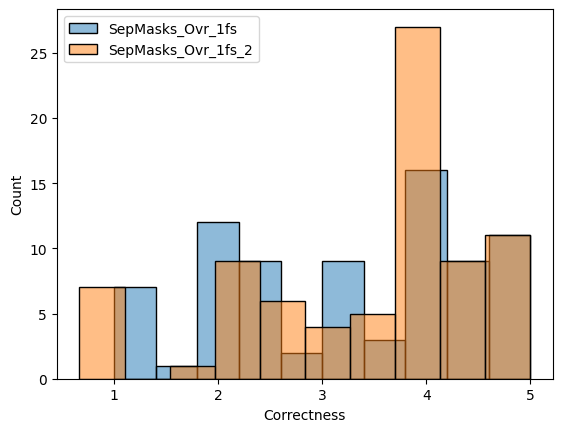

In [56]:
[sns.histplot(data_da.sel(metric="score").mean("pos_class").loc[var_n], bins=10, alpha=0.5, label=var_n)
 for var_n in var_names]
plt.xlabel('Correctness')
plt.ylabel('Count')
plt.legend()

## Per-Class

In [57]:
display(describe_da(data_da.sel(metric="pred").mean("img_idx"), dims_to_agg=["var"]))

/home/olivieri/.local/lib/python3.11/site-packages/xarray/computation/nanops.py:118: RuntimeWarning: invalid value encountered in divide
  data = data / (valid_count - ddof)
/opt/conda/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


stat,mean,std,min,max
pos_class,,,,
0,NaN,NaN,NaN,NaN
1,0.750000,0.117851,0.666667,0.833333
2,0.833333,0.235702,0.666667,1.000000
3,0.750000,0.353553,0.500000,1.000000
4,0.666667,0.000000,0.666667,0.666667
5,0.833333,0.000000,0.833333,0.833333
6,1.000000,0.000000,1.000000,1.000000
7,0.750000,0.353553,0.500000,1.000000
8,0.555556,0.314270,0.333333,0.777778


In [58]:
shape = len(data_da.coords["img_idx"]), len(data_da.coords["pos_class"])
table = xr.DataArray(np.empty(shape, dtype=object), coords=[data_da.coords["img_idx"], data_da.coords["pos_class"]]) # shape (n_imgs, n_pos_classes)

for img_idx in table.coords["img_idx"].values:
    significant_classes_gt = get_significant_classes(GTS_PATH / (image_UIDs[img_idx] + ".png"), 224, CLASS_MAP)
    for c in significant_classes_gt:
        if table.loc[img_idx, c] == None:
            table.loc[img_idx, c] = 1
class_counts = table.sum("img_idx")

/opt/conda/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


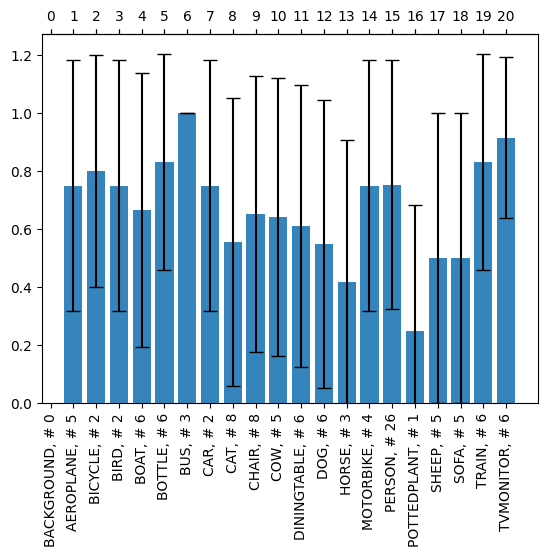

In [59]:
mean = data_da.sel(metric="pred").astype(float).mean(["img_idx", "var"])
std = data_da.sel(metric="pred").astype(float).std(["img_idx", "var"])
plt.bar([f"{CLASSES[i]}, # {int(class_counts[i])}" for i in mean.coords["pos_class"].values], mean, yerr=std, capsize=5, alpha=0.9)
plt.tick_params(axis='x', which='both', top=True)
top_ax = plt.gca().secondary_xaxis('top')
top_ax.set_xticks(range(len(mean.coords["pos_class"])))
top_ax.set_xticklabels(mean.coords["pos_class"].values)
plt.ylim(bottom=0)
plt.xticks(rotation=90)
plt.show()